# Metro Interstate Traffic Volume Analysis Notebook

## Data Importation

In [5]:
!ls

Analysis.ipynb	environment.yml      LICENSE	 Makefile   _toc.yml
_config.yml	figures		     logo.png	 models     traffic_tools
data		hw07-description.md  main.ipynb  README.md


In [1]:
# Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os
from traffic_tools import utils

In [2]:
traffic = pd.read_csv('data/Metro_Interstate_Traffic_Volume.csv')
traffic

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


## Introduction
Before doing EDA or further data anlysis, it is important to explore and perform data cleaning to check for any irregularities in the dataset and to see if any additional columns are needed. Our original data contains 9 columns and 48,204 rows. Specifically, the explanatory variables are holiday, temperature, amount of rain per hour, amount of snow per hour, coverage of clounds, type of weather, description of weather, and date time. The last column is the response variable traffic_volume.

In [3]:
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
traffic.shape

(48204, 9)

In [5]:
traffic.dtypes

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time               object
traffic_volume           int64
dtype: object

## Data Preprocessing

Upon observing the original data frame, we think it is helpful to extract new columns froms the `date_time` variable to better aid the analysis process. Thus, the `date`, `month`, and `hour` variables are created because these might be important factors that correlates to the traffic volume change.

In [6]:
# create new variables
traffic['date_time'] = pd.to_datetime(traffic.date_time)
traffic['date'] = traffic.date_time.dt.date
traffic['hour'] = traffic.date_time.dt.hour
traffic['month'] = traffic.date_time.dt.month

Weekday vs weekend affects traffic volume because each day of week may have different patterns. Therefore, categorical variable `weekday` is added to our dataset, another variable `is_weekend` is added with weekdays encoded as False and weekends encoded as True.

In [7]:
traffic['weekday'] = traffic.date_time.dt.weekday

traffic['is_weekend'] = traffic['weekday'].map(utils.encode_weekend)

We observe that there is one outlier for the `rain_1h`. We drop the irregular observation because it is clearly a mistake. For most observations, the amount of rain is 0 since there is no rain for most of the times. To better train our data, we transform the numerical variable of `rain_1h` to catagorical variables `rain_level` describing the level of rain.

/srv/conda/envs/notebook/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rain_1h'>

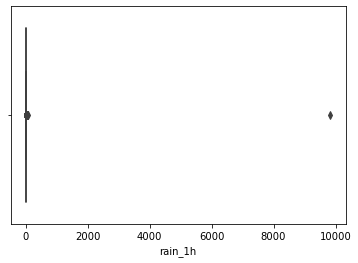

In [8]:
sns.boxplot('rain_1h', data = traffic)

In [9]:
traffic = traffic.loc[traffic.rain_1h<8000]

In [10]:

traffic['rain_level'] = traffic['rain_1h'].map(utils.encode_rain_level)

/tmp/ipykernel_2928/166673156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic['rain_level'] = traffic['rain_1h'].map(utils.encode_rain_level)


Similary, `snow_1h` is divided into 3 categories as the new column `snow_level`, with no snow, small snow, and big snow. 

In [12]:
traffic['snow_level'] = traffic['snow_1h'].map(utils.encode_snow_level)

/tmp/ipykernel_2928/486970302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic['snow_level'] = traffic['snow_1h'].map(utils.encode_snow_level)


The `temperature` variable in the original data uses the unit of kelvin. To better interpret the variable, we transform the unit to celsius. There are also outliers for the temperature which is also clearly mistakes, so we remove them.

In [13]:
traffic['temp'] = traffic['temp'] - 273.15

/tmp/ipykernel_2928/2526713493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic['temp'] = traffic['temp'] - 273.15


/srv/conda/envs/notebook/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='temp'>

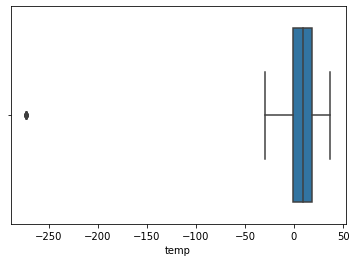

In [14]:
sns.boxplot('temp', data = traffic)

In [15]:
traffic = traffic.loc[traffic.temp >= -50]

For the `holiday` variable, there are many of them, but only holiday vs non-holiday should be useful. Therefore, this column is transformed into True or False.

In [16]:
traffic['holiday'] = traffic['holiday'].map(utils.encode_holiday)

## Finalized Dataset

Upon finishing the data preprocessing and cleaning, the final dataset has 48193 rows and 16 columns.

In [17]:
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,date,hour,month,weekday,is_weekend,rain_level,snow_level
0,False,15.13,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,2012-10-02,9,10,1,False,No rain,No snow
1,False,16.21,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,2012-10-02,10,10,1,False,No rain,No snow
2,False,16.43,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,2012-10-02,11,10,1,False,No rain,No snow
3,False,16.98,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,2012-10-02,12,10,1,False,No rain,No snow
4,False,17.99,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,2012-10-02,13,10,1,False,No rain,No snow


In [18]:
traffic.shape

(48193, 16)

## Explanatory Data Analysis

Before building any models or perforing any analysis, we need to perform data visualizations to see how the variables relate to each other.

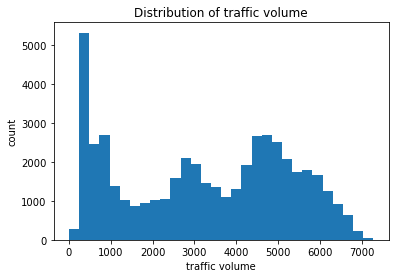

In [19]:
plt.hist(traffic.traffic_volume, bins = 30)
plt.title('Distribution of traffic volume')
plt.ylabel('count')
plt.xlabel('traffic volume');

Significant less traffic volume over weekends (5:Saturday, 6:Sunday)

<AxesSubplot:xlabel='weekday', ylabel='traffic_volume'>

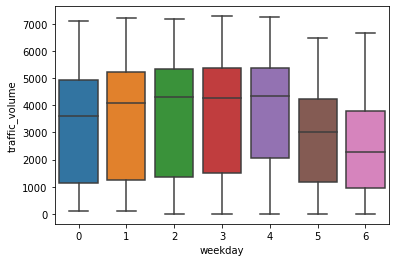

In [20]:
sns.boxplot(y='traffic_volume', x='weekday', data = traffic)

<AxesSubplot:xlabel='is_weekend', ylabel='traffic_volume'>

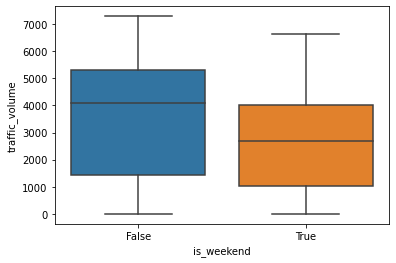

In [21]:
sns.boxplot(y='traffic_volume', x='is_weekend', data = traffic)

Not much difference for traffic volume across different months

<AxesSubplot:xlabel='month', ylabel='traffic_volume'>

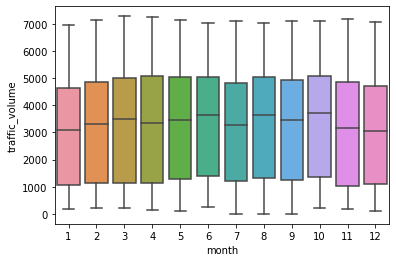

In [22]:
sns.boxplot(y='traffic_volume', x='month', data = traffic)

<AxesSubplot:xlabel='snow_level', ylabel='traffic_volume'>

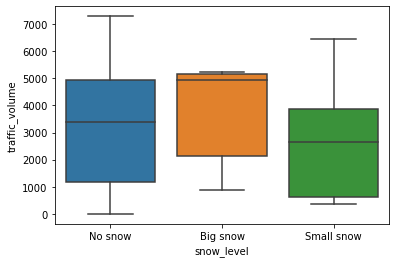

In [23]:
sns.boxplot(y='traffic_volume', x='snow_level', data = traffic)

<AxesSubplot:xlabel='rain_level', ylabel='traffic_volume'>

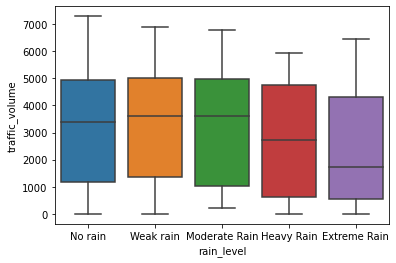

In [24]:
sns.boxplot(y='traffic_volume', x='rain_level', data = traffic)

### Research Question

Does different environmental variables (such as snow, rain, cloud, temperature, holiday, and weekend) impacts the level of traffic overall?

### Analysis and Interpretation of the Data


In [25]:
traffic

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,date,hour,month,weekday,is_weekend,rain_level,snow_level
0,False,15.13,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,2012-10-02,9,10,1,False,No rain,No snow
1,False,16.21,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,2012-10-02,10,10,1,False,No rain,No snow
2,False,16.43,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,2012-10-02,11,10,1,False,No rain,No snow
3,False,16.98,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,2012-10-02,12,10,1,False,No rain,No snow
4,False,17.99,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,2012-10-02,13,10,1,False,No rain,No snow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48199,False,10.30,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543,2018-09-30,19,9,6,True,No rain,No snow
48200,False,9.61,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781,2018-09-30,20,9,6,True,No rain,No snow
48201,False,9.58,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159,2018-09-30,21,9,6,True,No rain,No snow
48202,False,8.94,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450,2018-09-30,22,9,6,True,No rain,No snow


### Farther EDA

In [26]:
ols_traffic_model = traffic.copy()
ols_traffic_model['holiday'] = [0 if i == False else 1 for i in traffic['holiday']]
ols_traffic_model.drop(['weather_main', 'weather_description', 'date_time', 'date', 'weekday', 'rain_level', 'snow_level', 'month', 'hour'], axis=1, inplace=True)
ols_traffic_model['is_weekend'] = [0 if i == False else 1 for i in traffic['is_weekend']]
ols_traffic_model.columns = ['Holiday', 'Temperature (C)', 'Rain Level', 'Snow Level', 'Cloud Level', 'Traffic Volume', 'Weekend']

ols_traffic_model


,Holiday,Temperature (C),Rain Level,Snow Level,Cloud Level,Traffic Volume,Weekend
0,0,15.13,0.0,0.0,40,5545,0
1,0,16.21,0.0,0.0,75,4516,0
2,0,16.43,0.0,0.0,90,4767,0
3,0,16.98,0.0,0.0,90,5026,0
4,0,17.99,0.0,0.0,75,4918,0
...,...,...,...,...,...,...,...
48199,0,10.30,0.0,0.0,75,3543,1
48200,0,9.61,0.0,0.0,90,2781,1
48201,0,9.58,0.0,0.0,90,2159,1
48202,0,8.94,0.0,0.0,90,1450,1


### Difference-in-Difference Using Fit_OLS_Model

In [27]:
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

In [28]:
linear_model = fit_OLS_model(ols_traffic_model, 'Traffic Volume', ['Holiday', 'Temperature (C)', 'Rain Level', 'Snow Level', 'Cloud Level', 'Weekend'], intercept=True)
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:         Traffic Volume   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     649.3
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        02:39:17   Log-Likelihood:            -4.3250e+05
No. Observations:               48193   AIC:                         8.650e+05
Df Residuals:                   48186   BIC:                         8.651e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3162.6425     16.699    1

### Analysis and Interpretation of the Model

According to our Fit OLS Regression Model that we have built based on our variables, we tried to find a correlation between the level of Traffic and different variables that may influence the level of traffic. According to the summary of our model, we were able to find that there is overall positive correlation between the level of traffic and different environmental variables (snow, cloud, rain, temperature, holiday, weekend) in combined. For some of the unexpected discoveries we had, the most unexpected finding wasthe statistic significance on the snow level. Initially, we assumed that high level of snow would decrease the amount of traffic, but the result we discovered was very different from our expectation. The p-value for this factor came out to be 0.684, which was higher than 0.05. This also signifies that the snow does not have strong correlation on traffic level. For other coefficients on our variables, they were reasonably expected at the beginning of our hypothesis test as we expected that higher rain and snow would decrease the level of traffic. We expected a negative correlation because due to the danger of driving under restraint atmospheric conditions from snow and rain (which could hinder vision and increase chance of accident by less surface friction on the road), we expected less people to drive on those days. Similarly, we expected negative correlation between the traffic level and other variables, such as weekend and holiday, as less people would be driving to commute to work or they would more likely to stay at home. Other surprising foundings we had were correlation between cloud level/Temperature and traffic level as the coefficients were positive, but exceptionally smaller compared to other variables that had positive coefficients. This demonstrates that there are some possitive correlation between these factors, but weaker correlation compared to holiday, rain, snow, and weekend variables. 

### Conclusion

Given the interpretation between overall environmental factors and the traffic level, we are confident to say there are overall positive correlation between the combined environmental factors on the level of traffic overall, which can be found from the positive constant coefficient. There were some unexpected discoveries made  on the relationship between the level of traffic and snowiness of the weather, we found strongest correlation between the holiday variable and our target variable (Level of Traffic). Overall, the p-values for most of our variables were statistically significant, except the level of snow, ultimately supporting our hypothesis. 